In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset, TensorDataset
# import Ranger
from tqdm import tqdm # 进度条的库
import matplotlib.pyplot as plt
# import seaborn as sns
# import sklearn
# from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
# from sklearn.metrics import accuracy_score

# 读取数据

In [2]:
def unique_value(df: pd.DataFrame) -> np.array:
    df_specific = df.drop(list(df.columns[:2]), axis=1, inplace=False)
    temp = df_specific.to_numpy()
    return np.unique(temp)

In [3]:
train_df = pd.read_csv("../dataset/recipes_train.csv")
test_df = pd.read_csv("../dataset/recipes_test.csv")

In [4]:
train_df.shape, test_df.shape

((1469, 385), (979, 384))

In [5]:
train_df.head()

,id,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,1,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,chinese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,chinese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,korean,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,thai,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df.head()

,id,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# torch train

In [13]:
food_index = {}
food_count = {} # key为类, value为对应类的出现次数
loc_index = {} # key为类, value为其所有数据的索引
for _, group in train_df.groupby(by='cuisine'):
    # name, group = specific data -> DataFrame
    name = group['cuisine'].head(1).item()
    group.drop(["id", 'cuisine'], axis=1, inplace=True)
    loc_index[name] = group.index
    food_index[name] = group.sum().to_dict()
    food_count[name] = len(group)
food_index.keys() # key为类, value为类中各元素总和 dict: (column:sum_value)

dict_keys(['chinese', 'indian', 'japanese', 'korean', 'thai'])

In [14]:
def train(net, loss, train_dataset, valid_dataset, device, batch_size, shuffle, num_epoch, lr
          , lr_min, optim='sgd', init=True, scheduler_type='Cosine'):
    def init_xavier(m): # 参数初始化
        #if type(m) == nn.Linear or type(m) == nn.Conv2d:
        if type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight)

    if init:
        net.apply(init_xavier)

    print('training on:', device)
    net.to(device)
    
    # 构建dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)
    
    # 优化器选择
    if optim == 'sgd': 
        optimizer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad), lr=lr,
                                    weight_decay=0)
    elif optim == 'adam':
        optimizer = torch.optim.Adam((param for param in net.parameters() if param.requires_grad), lr=lr,
                                     weight_decay=0)
    elif optim == 'adamW':
        optimizer = torch.optim.AdamW((param for param in net.parameters() if param.requires_grad), lr=lr,
                                      weight_decay=0)
    # elif optim == 'ranger':
    #     optimizer = Ranger((param for param in net.parameters() if param.requires_grad), lr=lr,
    #                        weight_decay=0)
    
    # scheduler
    if scheduler_type == 'Cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=lr_min)
    
    # 用来保存每个epoch的Loss和acc以便最后画图
    train_losses = []
    train_acces = []
    eval_acces = []
    best_acc = 0.0
    
    # 训练
    for epoch in range(num_epoch):

        print("——————第 {} 轮训练开始——————".format(epoch + 1))

        # 训练开始
        net.train()
        train_acc = 0
        for batch in tqdm(train_dataloader, desc='训练'):
            # 放到对应device上
            sample, targets = batch
            sample = sample.to(device)
            targets = targets.to(device)
            output = net(sample)

            Loss = loss(output, targets)
          
            optimizer.zero_grad()
            Loss.backward()
            optimizer.step()

            _, pred = output.max(1)
            num_correct = (pred == targets).sum().item()
            acc = num_correct / (batch_size)
            train_acc += acc
        scheduler.step()
        print("epoch: {}, Loss: {}, Acc: {}".format(epoch, Loss.item(), train_acc / len(train_dataloader)))
        train_acces.append(train_acc / len(train_dataloader))
        train_losses.append(Loss.item())

        # 测试步骤开始
        net.eval()
        eval_loss = 0
        eval_acc = 0
        with torch.no_grad():
            for sample, targets in valid_dataloader:
                # 放到对应device上
                sample = sample.to(device)
                targets = targets.to(device)

                # 得到输出
                output = net(sample)
                Loss = loss(output, targets)
                _, pred = output.max(1)
                num_correct = (pred == targets).sum().item()
                eval_loss += Loss
                acc = num_correct / sample.shape[0]
                eval_acc += acc

            eval_losses = eval_loss / (len(valid_dataloader))
            eval_acc = eval_acc / (len(valid_dataloader))
            if eval_acc > best_acc:
                best_acc = eval_acc
                torch.save(net.state_dict(),'best_acc.pth')
            eval_acces.append(eval_acc)
            print("整体验证集上的Loss: {}".format(eval_losses))
            print("整体验证集上的正确率: {}".format(eval_acc))
    return train_losses, train_acces, eval_acces

In [15]:
# class MyDataSet(Dataset):
#     def __init__(self, loaded_data):
#         self.data = loaded_data
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         data = self.data.drop(['cuisine'], axis=1).values
#         label = self.data.loc[:, 'cuisine'].values
#         return data, label

In [16]:
cuisine_count = list(food_index.keys())
result_indices = np.array([])
for cuisine in cuisine_count:
    cur_features_names = [item[0] for item in food_index[cuisine].items() if item[1]!=0]
    cuisine_features = train_df.loc[loc_index[cuisine], cur_features_names]
    corr_matrix = cuisine_features.corr()
    # 只取相关度 > 0.7的特征
    high_corr_pairs = np.where(np.abs(corr_matrix) > 0.8)
    selected_feature_indices = np.unique(np.concatenate(high_corr_pairs))
    # 每次将不同cuisine获得的有意义的特征名称合并
    result_indices = np.union1d(result_indices, np.array(cur_features_names)[selected_feature_indices])

In [18]:
train_x = train_df[result_indices].values # 不要id
train_y = train_df["cuisine"].values
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=666)

# 字符串标签 -> int32
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_int = label_encoder.transform(y_train)
y_valid_int = label_encoder.transform(y_valid)

# int -> one-hot
# one_hot_encoder = LabelBinarizer()
# y_train_oh = one_hot_encoder.fit_transform(y_train_int)
# y_valid_oh = one_hot_encoder.fit_transform(y_valid_int)

In [30]:
# 获得可以使用于DataLoader的DataSet 也可以自己编写
train_dataset = TensorDataset(torch.from_numpy(X_train).to(torch.float32), \
                              torch.from_numpy(y_train_int).to(torch.int64))
valid_dataset = TensorDataset(torch.from_numpy(X_valid).to(torch.float32), \
                             torch.from_numpy(y_valid_int).to(torch.int64))

In [9]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features: list,  out_features):
        """
        :params in_features: 输入特征维度
        :params hidden_features: 隐藏层维度(由浅到深)
        :params out_features: 输出维度 
        """
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_features[0])
        self.relu1 = nn.ReLU()
        self.hidden_linears = []
        for i in range(1, len(hidden_features)):
            self.hidden_linears.append(nn.Linear(hidden_features[i-1], hidden_features[i]))
            self.hidden_linears.append(nn.ReLU())
        # 一定需要这一步变成ModuleList类型的, 不然会报错
        self.hidden_linears = torch.nn.ModuleList(self.hidden_linears) 
        self.last_linear = nn.Linear(hidden_features[-1], out_features)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, X):
        X = self.linear1(X)
        X = self.relu1(X)
        for hidden_linear in self.hidden_linears:
            X = hidden_linear(X)
        X = self.last_linear(X)
        X = self.softmax(X)
        return X

In [51]:
net = MLP(train_x.shape[1], [256, 64, 32], len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
loss = nn.CrossEntropyLoss() # label要是torch.int64类型的(不是one-hot)
train_losses, train_acces, eval_acces = train(net, loss, train_dataset=train_dataset, valid_dataset=valid_dataset, \
                                              device=device, batch_size=64, num_epoch=100, lr=1e-3, lr_min=1e-4, 
                                              optim='adam', init=True, shuffle=True)

training on: cuda
——————第 1 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 138.05it/s]


epoch: 0, Loss: 1.570589303970337, Acc: 0.47286184210526316
整体验证集上的Loss: 1.5928828716278076
整体验证集上的正确率: 0.5889802631578946
——————第 2 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 134.71it/s]


epoch: 1, Loss: 1.5345383882522583, Acc: 0.5789473684210527
整体验证集上的Loss: 1.5752111673355103
整体验证集上的正确率: 0.5638157894736843
——————第 3 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 127.86it/s]


epoch: 2, Loss: 1.4725587368011475, Acc: 0.5526315789473685
整体验证集上的Loss: 1.558209776878357
整体验证集上的正确率: 0.5572368421052631
——————第 4 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 85.67it/s] 


epoch: 3, Loss: 1.4502766132354736, Acc: 0.6167763157894737
整体验证集上的Loss: 1.5504003763198853
整体验证集上的正确率: 0.647203947368421
——————第 5 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 76.08it/s]


epoch: 4, Loss: 1.4533599615097046, Acc: 0.6866776315789473
整体验证集上的Loss: 1.5501266717910767
整体验证集上的正确率: 0.6564144736842106
——————第 6 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 106.01it/s]


epoch: 5, Loss: 1.4489691257476807, Acc: 0.7080592105263158
整体验证集上的Loss: 1.5467256307601929
整体验证集上的正确率: 0.7202302631578947
——————第 7 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 111.69it/s]


epoch: 6, Loss: 1.4932360649108887, Acc: 0.7072368421052632
整体验证集上的Loss: 1.548782229423523
整体验证集上的正确率: 0.7055921052631579
——————第 8 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 151.09it/s]


epoch: 7, Loss: 1.459407091140747, Acc: 0.7220394736842105
整体验证集上的Loss: 1.551383137702942
整体验证集上的正确率: 0.7036184210526316
——————第 9 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 162.83it/s]


epoch: 8, Loss: 1.4896605014801025, Acc: 0.7360197368421053
整体验证集上的Loss: 1.55320405960083
整体验证集上的正确率: 0.7106907894736842
——————第 10 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 148.07it/s]


epoch: 9, Loss: 1.449216604232788, Acc: 0.7541118421052632
整体验证集上的Loss: 1.553970217704773
整体验证集上的正确率: 0.7023026315789473
——————第 11 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 142.17it/s]


epoch: 10, Loss: 1.495160698890686, Acc: 0.7516447368421053
整体验证集上的Loss: 1.5489405393600464
整体验证集上的正确率: 0.7138157894736843
——————第 12 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 139.06it/s]


epoch: 11, Loss: 1.4590890407562256, Acc: 0.7615131578947368
整体验证集上的Loss: 1.5516791343688965
整体验证集上的正确率: 0.7210526315789474
——————第 13 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 150.01it/s]


epoch: 12, Loss: 1.4527332782745361, Acc: 0.7557565789473685
整体验证集上的Loss: 1.549109697341919
整体验证集上的正确率: 0.7215460526315789
——————第 14 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 145.43it/s]

epoch: 13, Loss: 1.4533120393753052, Acc: 0.7680921052631579


整体验证集上的Loss: 1.5516451597213745
整体验证集上的正确率: 0.7077302631578947
——————第 15 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 76.65it/s]


epoch: 14, Loss: 1.4770625829696655, Acc: 0.772203947368421
整体验证集上的Loss: 1.5501002073287964
整体验证集上的正确率: 0.7421052631578947
——————第 16 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 100.63it/s]


epoch: 15, Loss: 1.45146906375885, Acc: 0.7623355263157895
整体验证集上的Loss: 1.5504523515701294
整体验证集上的正确率: 0.7327302631578947
——————第 17 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 118.61it/s]


epoch: 16, Loss: 1.4500714540481567, Acc: 0.765625
整体验证集上的Loss: 1.5480432510375977
整体验证集上的正确率: 0.7077302631578947
——————第 18 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 120.46it/s]


epoch: 17, Loss: 1.450798511505127, Acc: 0.7689144736842105
整体验证集上的Loss: 1.5473734140396118
整体验证集上的正确率: 0.6949013157894737
——————第 19 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 151.20it/s]


epoch: 18, Loss: 1.492457389831543, Acc: 0.772203947368421
整体验证集上的Loss: 1.5515496730804443
整体验证集上的正确率: 0.7065789473684211
——————第 20 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 150.01it/s]


epoch: 19, Loss: 1.528638482093811, Acc: 0.765625
整体验证集上的Loss: 1.5486937761306763
整体验证集上的正确率: 0.7172697368421053
——————第 21 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 151.56it/s]


epoch: 20, Loss: 1.4735548496246338, Acc: 0.7557565789473685
整体验证集上的Loss: 1.5482836961746216
整体验证集上的正确率: 0.6981907894736843
——————第 22 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 151.93it/s]


epoch: 21, Loss: 1.4922045469284058, Acc: 0.7598684210526315
整体验证集上的Loss: 1.5484015941619873
整体验证集上的正确率: 0.7077302631578947
——————第 23 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 137.06it/s]


epoch: 22, Loss: 1.4757691621780396, Acc: 0.7738486842105263
整体验证集上的Loss: 1.549232840538025
整体验证集上的正确率: 0.7245065789473684
——————第 24 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 98.23it/s]


epoch: 23, Loss: 1.449338674545288, Acc: 0.7697368421052632
整体验证集上的Loss: 1.5481327772140503
整体验证集上的正确率: 0.7151315789473685
——————第 25 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 90.41it/s]


epoch: 24, Loss: 1.4489279985427856, Acc: 0.7680921052631579
整体验证集上的Loss: 1.5494965314865112
整体验证集上的正确率: 0.7222039473684211
——————第 26 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 93.20it/s] 


epoch: 25, Loss: 1.4515677690505981, Acc: 0.7738486842105263
整体验证集上的Loss: 1.5490866899490356
整体验证集上的正确率: 0.7348684210526316
——————第 27 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 104.21it/s]


epoch: 26, Loss: 1.4458473920822144, Acc: 0.772203947368421
整体验证集上的Loss: 1.5517100095748901
整体验证集上的正确率: 0.7327302631578947
——————第 28 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 127.68it/s]


epoch: 27, Loss: 1.4505674839019775, Acc: 0.7845394736842105
整体验证集上的Loss: 1.5475255250930786
整体验证集上的正确率: 0.7297697368421053
——————第 29 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 120.01it/s]


epoch: 28, Loss: 1.4815279245376587, Acc: 0.7935855263157895
整体验证集上的Loss: 1.553149700164795
整体验证集上的正确率: 0.7231907894736842
——————第 30 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 136.11it/s]


epoch: 29, Loss: 1.4516937732696533, Acc: 0.7779605263157895
整体验证集上的Loss: 1.5485706329345703
整体验证集上的正确率: 0.7305921052631579
——————第 31 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 145.43it/s]


epoch: 30, Loss: 1.4994723796844482, Acc: 0.7672697368421053
整体验证集上的Loss: 1.5503977537155151
整体验证集上的正确率: 0.7473684210526316
——————第 32 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 136.80it/s]


epoch: 31, Loss: 1.4483646154403687, Acc: 0.7935855263157895
整体验证集上的Loss: 1.5468209981918335
整体验证集上的正确率: 0.7266447368421053
——————第 33 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 157.45it/s]


epoch: 32, Loss: 1.4703813791275024, Acc: 0.7861842105263158
整体验证集上的Loss: 1.5487151145935059
整体验证集上的正确率: 0.7368421052631579
——————第 34 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 146.55it/s]


epoch: 33, Loss: 1.4469311237335205, Acc: 0.7935855263157895
整体验证集上的Loss: 1.552021861076355
整体验证集上的正确率: 0.6990131578947368
——————第 35 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 152.57it/s]


epoch: 34, Loss: 1.444973111152649, Acc: 0.7796052631578947
整体验证集上的Loss: 1.5508391857147217
整体验证集上的正确率: 0.694078947368421
——————第 36 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 77.92it/s]


epoch: 35, Loss: 1.4847285747528076, Acc: 0.7828947368421053
整体验证集上的Loss: 1.5488353967666626
整体验证集上的正确率: 0.7118421052631578
——————第 37 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 89.02it/s]


epoch: 36, Loss: 1.4476467370986938, Acc: 0.7886513157894737
整体验证集上的Loss: 1.5468230247497559
整体验证集上的正确率: 0.7328947368421053
——————第 38 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 113.95it/s]


epoch: 37, Loss: 1.4463595151901245, Acc: 0.7870065789473685
整体验证集上的Loss: 1.5461620092391968
整体验证集上的正确率: 0.7054276315789474
——————第 39 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 133.50it/s]


epoch: 38, Loss: 1.4477064609527588, Acc: 0.7779605263157895
整体验证集上的Loss: 1.553038239479065
整体验证集上的正确率: 0.7358552631578947
——————第 40 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 141.44it/s]


epoch: 39, Loss: 1.446173071861267, Acc: 0.7837171052631579
整体验证集上的Loss: 1.5472949743270874
整体验证集上的正确率: 0.727796052631579
——————第 41 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 138.05it/s]


epoch: 40, Loss: 1.4470374584197998, Acc: 0.7845394736842105
整体验证集上的Loss: 1.5476548671722412
整体验证集上的正确率: 0.7358552631578947
——————第 42 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 140.35it/s]


epoch: 41, Loss: 1.4469798803329468, Acc: 0.7894736842105263
整体验证集上的Loss: 1.545864462852478
整体验证集上的正确率: 0.7036184210526316
——————第 43 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 153.63it/s]


epoch: 42, Loss: 1.4461592435836792, Acc: 0.7870065789473685
整体验证集上的Loss: 1.5471172332763672
整体验证集上的正确率: 0.7442434210526316
——————第 44 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 141.14it/s]


epoch: 43, Loss: 1.4526019096374512, Acc: 0.7985197368421053
整体验证集上的Loss: 1.5558993816375732
整体验证集上的正确率: 0.7315789473684211
——————第 45 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 117.60it/s]

epoch: 44, Loss: 1.525040864944458, Acc: 0.7911184210526315
整体验证集上的Loss: 1.5467082262039185
整体验证集上的正确率: 0.7643092105263157
——————第 46 轮训练开始——————



训练: 100%|██████████| 19/19 [00:00<00:00, 78.61it/s]


epoch: 45, Loss: 1.4517253637313843, Acc: 0.7919407894736842
整体验证集上的Loss: 1.5482763051986694
整体验证集上的正确率: 0.7435855263157894
——————第 47 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 97.49it/s] 


epoch: 46, Loss: 1.45065438747406, Acc: 0.796875
整体验证集上的Loss: 1.5463695526123047
整体验证集上的正确率: 0.7442434210526316
——————第 48 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 115.43it/s]


epoch: 47, Loss: 1.44961416721344, Acc: 0.7919407894736842
整体验证集上的Loss: 1.5492242574691772
整体验证集上的正确率: 0.7348684210526316
——————第 49 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 110.05it/s]


epoch: 48, Loss: 1.4505012035369873, Acc: 0.7944078947368421
整体验证集上的Loss: 1.5474944114685059
整体验证集上的正确率: 0.725328947368421
——————第 50 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 152.41it/s]


epoch: 49, Loss: 1.4470133781433105, Acc: 0.7911184210526315
整体验证集上的Loss: 1.5478028059005737
整体验证集上的正确率: 0.7148026315789473
——————第 51 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 132.41it/s]


epoch: 50, Loss: 1.4489878416061401, Acc: 0.7894736842105263
整体验证集上的Loss: 1.5477312803268433
整体验证集上的正确率: 0.7338815789473684
——————第 52 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 135.11it/s]


epoch: 51, Loss: 1.4634374380111694, Acc: 0.7919407894736842
整体验证集上的Loss: 1.5495350360870361
整体验证集上的正确率: 0.6929276315789473
——————第 53 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 146.21it/s]


epoch: 52, Loss: 1.4580485820770264, Acc: 0.7861842105263158
整体验证集上的Loss: 1.5502790212631226
整体验证集上的正确率: 0.7055921052631579
——————第 54 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 144.32it/s]


epoch: 53, Loss: 1.4471126794815063, Acc: 0.7828947368421053
整体验证集上的Loss: 1.5544945001602173
整体验证集上的正确率: 0.7161184210526316
——————第 55 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 127.46it/s]

epoch: 54, Loss: 1.4926044940948486, Acc: 0.7935855263157895
整体验证集上的Loss: 1.5488134622573853
整体验证集上的正确率: 0.725328947368421
——————第 56 轮训练开始——————



训练: 100%|██████████| 19/19 [00:00<00:00, 81.55it/s]


epoch: 55, Loss: 1.4488343000411987, Acc: 0.796875
整体验证集上的Loss: 1.5457576513290405
整体验证集上的正确率: 0.7307565789473685
——————第 57 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 86.28it/s] 


epoch: 56, Loss: 1.4478098154067993, Acc: 0.7935855263157895
整体验证集上的Loss: 1.5494420528411865
整体验证集上的正确率: 0.7241776315789473
——————第 58 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 98.19it/s]


epoch: 57, Loss: 1.4920344352722168, Acc: 0.7911184210526315
整体验证集上的Loss: 1.5467469692230225
整体验证集上的正确率: 0.7557565789473684
——————第 59 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 102.35it/s]


epoch: 58, Loss: 1.450230598449707, Acc: 0.7993421052631579
整体验证集上的Loss: 1.5498194694519043
整体验证集上的正确率: 0.6980263157894737
——————第 60 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 127.86it/s]


epoch: 59, Loss: 1.4908448457717896, Acc: 0.790296052631579
整体验证集上的Loss: 1.546622395515442
整体验证集上的正确率: 0.7116776315789474
——————第 61 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 118.74it/s]


epoch: 60, Loss: 1.4450839757919312, Acc: 0.7944078947368421
整体验证集上的Loss: 1.5495007038116455
整体验证集上的正确率: 0.7254934210526316
——————第 62 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 130.48it/s]


epoch: 61, Loss: 1.4464128017425537, Acc: 0.8018092105263158
整体验证集上的Loss: 1.5489531755447388
整体验证集上的正确率: 0.7495065789473684
——————第 63 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 128.04it/s]


epoch: 62, Loss: 1.490279197692871, Acc: 0.7853618421052632
整体验证集上的Loss: 1.5469914674758911
整体验证集上的正确率: 0.7421052631578947
——————第 64 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 125.22it/s]


epoch: 63, Loss: 1.448603630065918, Acc: 0.7944078947368421
整体验证集上的Loss: 1.5468653440475464
整体验证集上的正确率: 0.7399671052631579
——————第 65 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 129.62it/s]


epoch: 64, Loss: 1.4457283020019531, Acc: 0.7952302631578947
整体验证集上的Loss: 1.5502246618270874
整体验证集上的正确率: 0.740953947368421
——————第 66 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 82.64it/s]


epoch: 65, Loss: 1.4458191394805908, Acc: 0.8001644736842105
整体验证集上的Loss: 1.5533084869384766
整体验证集上的正确率: 0.7213815789473684
——————第 67 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 79.19it/s]


epoch: 66, Loss: 1.4417206048965454, Acc: 0.8018092105263158
整体验证集上的Loss: 1.5521405935287476
整体验证集上的正确率: 0.7189144736842106
——————第 68 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 102.84it/s]


epoch: 67, Loss: 1.4845483303070068, Acc: 0.8092105263157895
整体验证集上的Loss: 1.5493329763412476
整体验证集上的正确率: 0.7527960526315789
——————第 69 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 114.00it/s]


epoch: 68, Loss: 1.4453799724578857, Acc: 0.803453947368421
整体验证集上的Loss: 1.549665093421936
整体验证集上的正确率: 0.7430921052631578
——————第 70 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 126.33it/s]


epoch: 69, Loss: 1.4484939575195312, Acc: 0.7976973684210527
整体验证集上的Loss: 1.5467551946640015
整体验证集上的正确率: 0.7222039473684211
——————第 71 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 141.59it/s]


epoch: 70, Loss: 1.4431617259979248, Acc: 0.8026315789473685
整体验证集上的Loss: 1.5485857725143433
整体验证集上的正确率: 0.7368421052631579
——————第 72 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 98.82it/s]


epoch: 71, Loss: 1.4475905895233154, Acc: 0.8116776315789473
整体验证集上的Loss: 1.5476710796356201
整体验证集上的正确率: 0.7495065789473684
——————第 73 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 129.56it/s]


epoch: 72, Loss: 1.4460386037826538, Acc: 0.8018092105263158
整体验证集上的Loss: 1.5461549758911133
整体验证集上的正确率: 0.7294407894736843
——————第 74 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 131.38it/s]


epoch: 73, Loss: 1.4493640661239624, Acc: 0.8067434210526315
整体验证集上的Loss: 1.5498555898666382
整体验证集上的正确率: 0.7578947368421053
——————第 75 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 142.57it/s]


epoch: 74, Loss: 1.489606261253357, Acc: 0.7993421052631579
整体验证集上的Loss: 1.548282504081726
整体验证集上的正确率: 0.7421052631578947
——————第 76 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 110.12it/s]


epoch: 75, Loss: 1.4465488195419312, Acc: 0.8083881578947368
整体验证集上的Loss: 1.5505781173706055
整体验证集上的正确率: 0.7442434210526316
——————第 77 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 66.89it/s]


epoch: 76, Loss: 1.4456706047058105, Acc: 0.8001644736842105
整体验证集上的Loss: 1.5459400415420532
整体验证集上的正确率: 0.7557565789473684
——————第 78 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 102.03it/s]


epoch: 77, Loss: 1.4470341205596924, Acc: 0.805921052631579
整体验证集上的Loss: 1.5476237535476685
整体验证集上的正确率: 0.7506578947368421
——————第 79 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 122.46it/s]


epoch: 78, Loss: 1.4462522268295288, Acc: 0.803453947368421
整体验证集上的Loss: 1.5459293127059937
整体验证集上的正确率: 0.7559210526315789
——————第 80 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 122.91it/s]


epoch: 79, Loss: 1.44496488571167, Acc: 0.8125
整体验证集上的Loss: 1.548201322555542
整体验证集上的正确率: 0.7651315789473684
——————第 81 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 143.69it/s]


epoch: 80, Loss: 1.4490646123886108, Acc: 0.803453947368421
整体验证集上的Loss: 1.5468729734420776
整体验证集上的正确率: 0.7546052631578947
——————第 82 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 143.29it/s]


epoch: 81, Loss: 1.4478942155838013, Acc: 0.8050986842105263
整体验证集上的Loss: 1.5499173402786255
整体验证集上的正确率: 0.7620065789473685
——————第 83 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 120.27it/s]


epoch: 82, Loss: 1.4449831247329712, Acc: 0.8026315789473685
整体验证集上的Loss: 1.5487571954727173
整体验证集上的正确率: 0.743421052631579
——————第 84 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 134.16it/s]


epoch: 83, Loss: 1.4481909275054932, Acc: 0.7985197368421053
整体验证集上的Loss: 1.5513836145401
整体验证集上的正确率: 0.703125
——————第 85 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 86.71it/s] 


epoch: 84, Loss: 1.489413857460022, Acc: 0.8009868421052632
整体验证集上的Loss: 1.552956461906433
整体验证集上的正确率: 0.6990131578947368
——————第 86 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 91.64it/s]


epoch: 85, Loss: 1.451772928237915, Acc: 0.8050986842105263
整体验证集上的Loss: 1.5522922277450562
整体验证集上的正确率: 0.7462171052631579
——————第 87 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 103.28it/s]


epoch: 86, Loss: 1.4461004734039307, Acc: 0.8083881578947368
整体验证集上的Loss: 1.5483484268188477
整体验证集上的正确率: 0.7537828947368421
——————第 88 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 98.84it/s]


epoch: 87, Loss: 1.4454141855239868, Acc: 0.8116776315789473
整体验证集上的Loss: 1.553800344467163
整体验证集上的正确率: 0.7233552631578947
——————第 89 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 95.49it/s] 


epoch: 88, Loss: 1.4540033340454102, Acc: 0.8125
整体验证集上的Loss: 1.5474821329116821
整体验证集上的正确率: 0.7598684210526316
——————第 90 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 105.84it/s]


epoch: 89, Loss: 1.4497052431106567, Acc: 0.8092105263157895
整体验证集上的Loss: 1.5537313222885132
整体验证集上的正确率: 0.7422697368421053
——————第 91 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 129.01it/s]


epoch: 90, Loss: 1.4468156099319458, Acc: 0.8026315789473685
整体验证集上的Loss: 1.5510337352752686
整体验证集上的正确率: 0.7095394736842106
——————第 92 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 99.97it/s]


epoch: 91, Loss: 1.4829444885253906, Acc: 0.8018092105263158
整体验证集上的Loss: 1.5471500158309937
整体验证集上的正确率: 0.7534539473684211
——————第 93 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 128.63it/s]


epoch: 92, Loss: 1.446069359779358, Acc: 0.8100328947368421
整体验证集上的Loss: 1.5469542741775513
整体验证集上的正确率: 0.749671052631579
——————第 94 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 133.57it/s]


epoch: 93, Loss: 1.4669464826583862, Acc: 0.8100328947368421
整体验证集上的Loss: 1.5473908185958862
整体验证集上的正确率: 0.7547697368421054
——————第 95 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 113.01it/s]


epoch: 94, Loss: 1.446407437324524, Acc: 0.8050986842105263
整体验证集上的Loss: 1.548064112663269
整体验证集上的正确率: 0.7600328947368421
——————第 96 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 94.05it/s] 


epoch: 95, Loss: 1.4460562467575073, Acc: 0.8009868421052632
整体验证集上的Loss: 1.5454691648483276
整体验证集上的正确率: 0.7495065789473684
——————第 97 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 81.68it/s]


epoch: 96, Loss: 1.4462611675262451, Acc: 0.8075657894736842
整体验证集上的Loss: 1.5489301681518555
整体验证集上的正确率: 0.740953947368421
——————第 98 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 114.85it/s]


epoch: 97, Loss: 1.4444139003753662, Acc: 0.8042763157894737
整体验证集上的Loss: 1.5481716394424438
整体验证集上的正确率: 0.7463815789473685
——————第 99 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 120.71it/s]


epoch: 98, Loss: 1.4464561939239502, Acc: 0.8083881578947368
整体验证集上的Loss: 1.5481878519058228
整体验证集上的正确率: 0.7429276315789474
——————第 100 轮训练开始——————


训练: 100%|██████████| 19/19 [00:00<00:00, 131.38it/s]

epoch: 99, Loss: 1.4468317031860352, Acc: 0.8083881578947368
整体验证集上的Loss: 1.5464153289794922
整体验证集上的正确率: 0.7421052631578947


# visualize losses and acces

In [46]:
def show_acces(train_losses, train_acces, valid_acces): # 对准确率和loss画图显得直观
    plt.plot(1 + np.arange(len(train_losses)), train_losses, linewidth=1.5, linestyle='dashed', label='train_losses')
    plt.plot(1 + np.arange(len(train_acces)), train_acces, linewidth=1.5, linestyle='dashed', label='train_acces')
    plt.plot(1 + np.arange(len(valid_acces)), valid_acces, linewidth=1.5, linestyle='dashed', label='valid_acces')
    plt.grid()
    plt.xlabel('epoch')
    # plt.xticks(range(1, 1 + num_epoch, 1))
    plt.legend()
    plt.show()

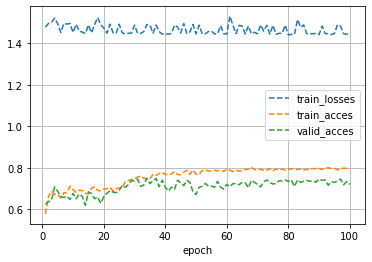

In [49]:
show_acces(train_losses, train_acces, eval_acces)

# torch predict

In [32]:
def predict(test_loader, model, device):
    model.to(device)
    model.eval() # Set your model to evaluation mode.
    preds = []

    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():                   
            pred = model(x)
            _, pred = pred.max(1)         
            preds.append(pred.detach().cpu()) # 读出无grad类型的数据
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [19]:
model_state = torch.load("./best_acc.pth")
model = MLP(train_x.shape[1], [256, 64, 32], len(label_encoder.classes_))
model.load_state_dict(model_state)

<All keys matched successfully>

In [25]:
class MytestDataSet(Dataset):
    def __init__(self, x):
        self.x = torch.FloatTensor(x)
    
    def __getitem__(self, idx):
        return self.x[idx]
    
    def __len__(self):
        return len(self.x)

In [26]:
test_data = test_df[result_indices].values
test_dataset = MytestDataSet(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [34]:
result = predict(test_loader=test_dataloader, model=model, device='cuda')
result = label_encoder.inverse_transform(result)

100%|██████████| 62/62 [00:00<00:00, 634.35it/s]
